# CNN autoencoder: training and visualization
## Tutor: Pavlo Bilous (MPL)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/04_tutorial_cnn_visual.ipynb)

## 0. Imports

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

## 1. What are our images

Image 64 x 64 shows a square covering coordinates (-1, 1) x (-1, 1)  
with a circle of radius "r" centered at (xc, yc)

### 1.a) Pixels (fixed once and forever):

In [2]:
pix = 64

x_edges = jnp.linspace(-1, 1, pix + 1)
x_middles = (x_edges[1:] + x_edges[:-1]) / 2

y_middles = x_middles

xx, yy = jnp.meshgrid(x_middles, y_middles)

### 1.b) Drawing circles:

In [3]:
def draw_circle(r, xc, yc):
    where_circle = (xx - xc)**2 + (yy - yc)**2 <= r**2
    cc = where_circle.astype(float)
    return cc

In [4]:
cc = draw_circle(0.7, 0.2, 0.5)

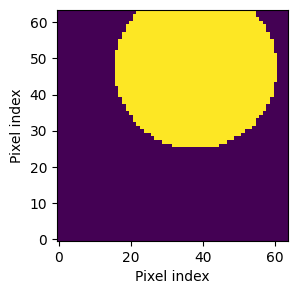

In [5]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cc);
plt.gca().invert_yaxis();
ax.set_xlabel("Pixel index");
ax.set_ylabel("Pixel index");

## 2. Data generation

1 batch = 32 images  
with circles of random radius (between 0 and 1)  
and with canters placed randomly in the square

### 2.a) Batch creation:

In [6]:
draw_circles = jax.vmap(draw_circle)

In [7]:
def create_data_batch(key, batch_size=32):
    
    key, subkey = jax.random.split(key)
    xc = jax.random.uniform(subkey, shape=(batch_size,), minval=-1.0, maxval=1.0)

    key, subkey = jax.random.split(key)
    yc = jax.random.uniform(subkey, shape=(batch_size,), minval=-1.0, maxval=1.0)

    key, subkey = jax.random.split(key)
    r = jax.random.uniform(subkey, shape=(batch_size,), minval=0.0, maxval=1.0)
    
    return draw_circles(r, xc, yc)

In [24]:
key = jax.random.key(seed=1234)
key, subkey = jax.random.split(key)

data_batch = create_data_batch(subkey)

### 2.b) Batch visualization

In [25]:
def plot_images(data_batch, label, how_many=5): 
    print(f">>> {label}:")
    
    fig, axes = plt.subplots(1, how_many, sharey=True, subplot_kw=dict(box_aspect=1))
    
    for ax, cc in zip(axes, data_batch):
        im = ax.imshow(cc);
        ax.set_xticks([]);
        ax.set_yticks([]);

    fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.01, pad=0.04);
    
    plt.gca().invert_yaxis();

>>> Batch example:


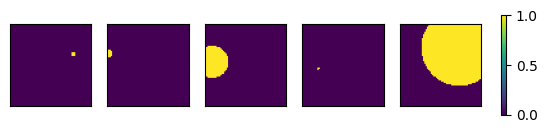

In [13]:
plot_images(data_batch, "Batch example")

### 2.c) Pack into a generator:

In [17]:
def make_batch_generator(key):
    while True:
        key, subkey = jax.random.split(key)
        data_batch = create_data_batch(subkey)
        data_batch = data_batch[..., jnp.newaxis]
        yield data_batch

In [18]:
key = jax.random.key(seed=1234)
batch_generator = make_batch_generator(key)

>>> Batch example:


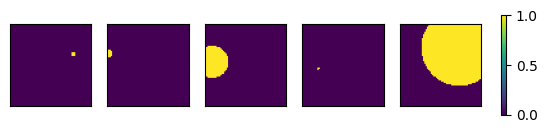

In [19]:
data_batch = next(batch_generator)

plot_images(data_batch, "Batch example")

## 3. FLAX neural network

In [26]:
import flax.linen as nn
import optax
from flax.training.train_state import TrainState

### 3.a) Define and initialize model

In [27]:
class MyConvModel(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(10, (3, 3), padding='same')(x)
        x = nn.sigmoid(x)
        x = nn.Conv(1, (3, 3), padding='same')(x)
        return x

In [28]:
my_conv_model = MyConvModel()

In [29]:
my_conv_model = MyConvModel()

dummy_input = jnp.ones(shape=(pix, pix, 1))

key, subkey = jax.random.split(key)
params = my_conv_model.init(subkey, dummy_input)["params"]

In [30]:
column_params = dict(overflow="fold")

table = my_conv_model.tabulate(jax.random.key(0), dummy_input, column_kwargs=column_params)

print( table )


                              MyConvModel Summary                              
┌────────┬─────────────┬─────────────────┬─────────────────┬──────────────────┐
│ path   │ module      │ inputs          │ outputs         │ params           │
├────────┼─────────────┼─────────────────┼─────────────────┼──────────────────┤
│        │ MyConvModel │ float32[64,64,1 │ float32[64,64,1 │                  │
│        │             │ ]               │ ]               │                  │
├────────┼─────────────┼─────────────────┼─────────────────┼──────────────────┤
│ Conv_0 │ Conv        │ float32[64,64,1 │ float32[64,64,1 │ bias:            │
│        │             │ ]               │ 0]              │ float32[10]      │
│        │             │                 │                 │ kernel:          │
│        │             │                 │                 │ float32[3,3,1,10 │
│        │             │                 │                 │ ]                │
│        │             │               

### 3.b) Create optimizer

In [31]:
optimizer = optax.adam(learning_rate=0.005)

### 3.c) Bundle all together in one "state"

In [32]:
state = TrainState.create(apply_fn=my_conv_model.apply, params=params, tx=optimizer)

### 3.d) Write training / prediction functions

In [33]:
def predict_on_batch(state, X):
    return state.apply_fn({'params': state.params}, X)

In [34]:
@jax.jit
def train_on_batch(state, X, y):

    def loss_fn(params):
        y_pred = state.apply_fn({'params': params}, X)
        sq_dev = (y_pred - y)**2
        mean_sq_dev = sq_dev.mean()
        return mean_sq_dev

    val_and_grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = val_and_grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return loss, state

## 4. Try it out

### 4.a) Prediction by untrained NN

In [35]:
X = next(batch_generator)
y_true = X

In [36]:
y_predicted = predict_on_batch(state, X)

>>> True images:


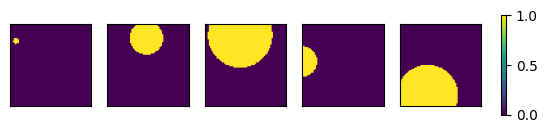

In [37]:
plot_images(y_true, "True images")

>>> Predicted images (untrained):


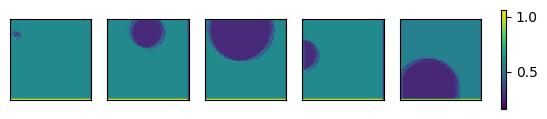

In [38]:
plot_images(y_predicted, "Predicted images (untrained)")

### 4.b) Training

In [39]:
losses = []

for i in range(100):
    
    X = next(batch_generator)
    y_true = X
    
    loss, state = train_on_batch(state, X, y_true)

    losses.append(loss)

    if (i + 1) % 10 == 0:
        print(f"Batch: {i + 1}\tloss = {loss:.3e}")

Batch: 10	loss = 1.544e-01
Batch: 20	loss = 4.424e-02
Batch: 30	loss = 1.663e-02
Batch: 40	loss = 9.728e-03
Batch: 50	loss = 9.732e-03
Batch: 60	loss = 7.742e-03
Batch: 70	loss = 6.613e-03
Batch: 80	loss = 6.710e-03
Batch: 90	loss = 5.136e-03
Batch: 100	loss = 6.653e-03


### 4.c) Prediction by trained NN

>>> Predicted images (trained)::


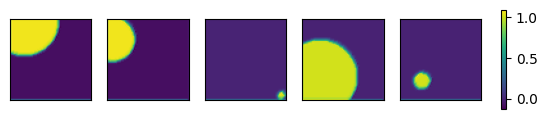

In [40]:
X = next(batch_generator)
y_true = X

y_predicted = predict_on_batch(state, X)

plot_images(y_predicted, "Predicted images (trained):")

## 5. Conv. autoencoder

### 5.a) Create the NN setup (repetition)

In [41]:
def up_sample_2d(x, factors):
    new_shape = list(x.shape)
    
    new_shape[-3] *= factors[0]
    new_shape[-2] *= factors[1]
    
    x = jax.image.resize(x, shape=new_shape, method='bilinear')

    return x

In [42]:
class ConvAutoenc(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)
        x = nn.pooling.avg_pool(x, (4, 4), strides=(4, 4))
        
        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)
        x = nn.pooling.avg_pool(x, (2, 2), strides=(2, 2))

        x = nn.Conv(1, (3, 3), padding='same')(x)
        x = nn.sigmoid(x)
        
        x = up_sample_2d(x, (2, 2))
        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)
        
        x = up_sample_2d(x, (4, 4))
        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)
        
        x = nn.Conv(1, (3, 3), padding='same')(x)       
        
        return x

In [43]:
conv_autoenc = ConvAutoenc()

dummy_input = jnp.ones(shape=(pix, pix, 1))

key, subkey = jax.random.split(key)
params = conv_autoenc.init(subkey, dummy_input)["params"]

In [44]:
column_params = dict(overflow="fold")

table = conv_autoenc.tabulate(jax.random.key(0), dummy_input, column_kwargs=column_params)

print( table )


                              ConvAutoenc Summary                              
┌────────┬─────────────┬─────────────────┬──────────────────┬─────────────────┐
│ path   │ module      │ inputs          │ outputs          │ params          │
├────────┼─────────────┼─────────────────┼──────────────────┼─────────────────┤
│        │ ConvAutoenc │ float32[64,64,1 │ float32[64,64,1] │                 │
│        │             │ ]               │                  │                 │
├────────┼─────────────┼─────────────────┼──────────────────┼─────────────────┤
│ Conv_0 │ Conv        │ float32[64,64,1 │ float32[64,64,4] │ bias:           │
│        │             │ ]               │                  │ float32[4]      │
│        │             │                 │                  │ kernel:         │
│        │             │                 │                  │ float32[5,5,1,4 │
│        │             │                 │                  │ ]               │
│        │             │               

In [45]:
optimizer = optax.adam(learning_rate=0.005)

In [46]:
state = TrainState.create(apply_fn=conv_autoenc.apply, params=params, tx=optimizer)

### 5.b) Training

In [47]:
losses = []

In [48]:
for i in range(2000):
    
    X = next(batch_generator)
    y_true = X
    
    loss, state = train_on_batch(state, X, y_true)

    losses.append(loss)

    if (i + 1) % 100 == 0:
        print(f"Batch: {i + 1}\tloss = {loss:.3e}")

Batch: 100	loss = 1.585e-01
Batch: 200	loss = 5.316e-02
Batch: 300	loss = 3.201e-02
Batch: 400	loss = 2.793e-02
Batch: 500	loss = 2.542e-02
Batch: 600	loss = 1.712e-02
Batch: 700	loss = 1.477e-02
Batch: 800	loss = 1.491e-02
Batch: 900	loss = 1.233e-02
Batch: 1000	loss = 1.340e-02
Batch: 1100	loss = 1.319e-02
Batch: 1200	loss = 1.121e-02
Batch: 1300	loss = 1.289e-02
Batch: 1400	loss = 1.297e-02
Batch: 1500	loss = 1.079e-02
Batch: 1600	loss = 1.172e-02
Batch: 1700	loss = 1.223e-02
Batch: 1800	loss = 1.347e-02
Batch: 1900	loss = 1.273e-02
Batch: 2000	loss = 1.201e-02


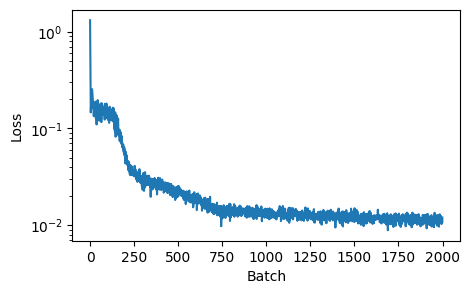

In [49]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(losses);
ax.set_yscale("log");

ax.set_xlabel("Batch");
ax.set_ylabel("Loss");

### 5.c) Visualization of reproduced images

In [50]:
X = next(batch_generator)
y_true = X

y_predicted = predict_on_batch(state, X)

>>> True images:


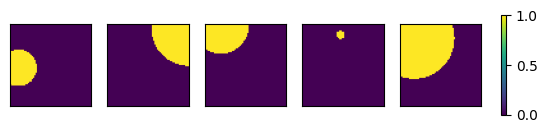

In [51]:
plot_images(y_true, "True images")

>>> Predicted images (trained)::


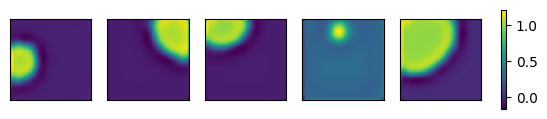

In [52]:
plot_images(y_predicted, "Predicted images (trained):")

### 5.d) Visualization of encoded images

In [53]:
class Encoder(nn.Module):

    @nn.compact
    def __call__(self, x):
        
        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)
        x = nn.pooling.avg_pool(x, (4, 4), strides=(4, 4))
        
        x = nn.Conv(4, (5, 5), padding='same')(x)
        x = nn.sigmoid(x)
        x = nn.pooling.avg_pool(x, (2, 2), strides=(2, 2))

        x = nn.Conv(1, (3, 3), padding='same')(x)
        x = nn.sigmoid(x)
        
        return x
    
encoder = Encoder()

In [54]:
column_params = dict(overflow="fold")
dummy_input = jnp.ones(shape=(pix, pix, 1))
table = encoder.tabulate(jax.random.key(0), dummy_input, column_kwargs=column_params)
print( table )


                                Encoder Summary                                
┌────────┬─────────┬──────────────────┬──────────────────┬────────────────────┐
│ path   │ module  │ inputs           │ outputs          │ params             │
├────────┼─────────┼──────────────────┼──────────────────┼────────────────────┤
│        │ Encoder │ float32[64,64,1] │ float32[8,8,1]   │                    │
├────────┼─────────┼──────────────────┼──────────────────┼────────────────────┤
│ Conv_0 │ Conv    │ float32[64,64,1] │ float32[64,64,4] │ bias: float32[4]   │
│        │         │                  │                  │ kernel:            │
│        │         │                  │                  │ float32[5,5,1,4]   │
│        │         │                  │                  │                    │
│        │         │                  │                  │ 104 (416 B)        │
├────────┼─────────┼──────────────────┼──────────────────┼────────────────────┤
│ Conv_1 │ Conv    │ float32[16,16,4] │

In [55]:
params_enc = {key: value for key, value in state.params.items() if int(key[-1]) < 3}

In [56]:
encoded_img = encoder.apply({'params': params_enc}, X)

>>> Encoded images:


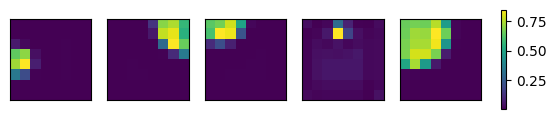

In [57]:
plot_images(encoded_img, "Encoded images")